In [1]:
%load_ext autoreload
import sys
import gc
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
from multi_mode import *
from coupled_fluxonium import *
from branch_analysis_w_chain import *

In [3]:
EJ  = 2.040
EL  = .091
EC  = 1.083
g_n = .062
f_r = 6.627
chain_trunc = 4

EC_a = .0001
EJ_a = 20
cg_a = 1e-6
c_a  = 1e-6
num_JJ = 204
g_chain = get_g_chain(EJ, EC_a, EJ_a, cg_a, c_a, num_JJ, chain_trunc)
print(g_chain)
g_chain = 2*g_chain

0.0402561340481539


In [9]:
# Setting some vals
f_trunc    = 40
ncut       = 40
osc_trunc  = 80
flux       = 0
lookup     = False

coupling_type = 'capacitive'
f_c = 1.6
chain_mode = True
fit_params = {}
# Tuple for moving stuff around

# This may be excessive but it feels more flexible
# if things need to change
var_list = ['f_trunc', 'ncut', 'osc_trunc', 'flux', 'lookup', 'EJ', 'EL', 'EC', 
            'g_n', 'f_r', 'coupling_type', 'chain_mode', 'chain_trunc', 'g_chain',
            'f_c']

units = {'flux': r"$\Phi_0$"}
_locals = locals()

fit_params.update({
    name: (_locals[name], units.get(name), None)
    for name in var_list
})

In [10]:
H = CoupledFluxonium(fit_params)

In [11]:
pkg, H_full = get_objs(fit_params, 'fluxonium')

In [12]:
res = branch_analysis(pkg, update_flux=False)
params, data, params_list, data_list, branches, dressed_evals, dressed_evecs = res

climbing ladders...: 100%|#############################################################| 79/79 [22:00<00:00, 16.71s/it]


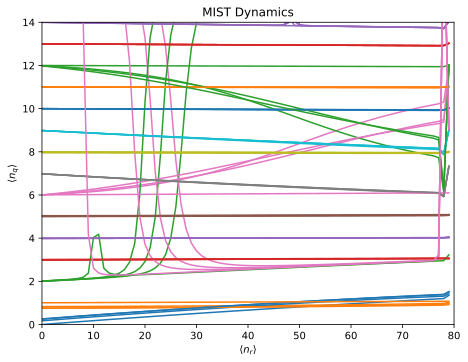

In [13]:
for data_temp in data_list:
    plt.plot(data_temp[f'n_q'][0])
plt.xlim(0, 80)
plt.ylim(0, 14)
plt.tight_layout()
plt.xlabel(r'$⟨n_r⟩$')
plt.ylabel(r'$⟨n_q⟩$')
plt.title('MIST Dynamics')
plt.savefig('MIST w chain modes')

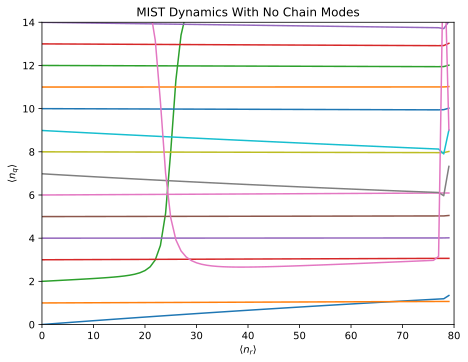

In [37]:
for data_temp in data_list:
    plt.plot(data_temp[f'n_q'][0])
plt.xlim(0, 80)
plt.ylim(0, 14)
plt.tight_layout()
plt.xlabel(r'$⟨n_r⟩$')
plt.ylabel(r'$⟨n_q⟩$')
plt.title('MIST Dynamics With No Chain Modes')
plt.savefig('MIST base_no_chain')

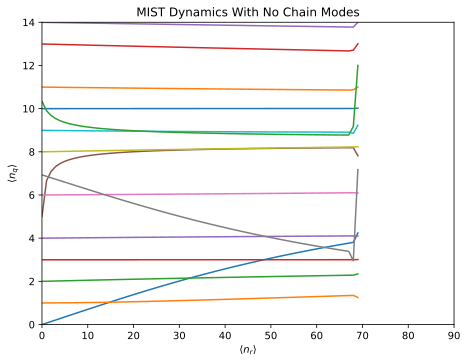

In [24]:
for data_temp in data_list:
    plt.plot(data_temp[f'n_q'][0])
plt.xlim(0, 90)
plt.ylim(0, 14)
plt.tight_layout()
plt.xlabel(r'$⟨n_r⟩$')
plt.ylabel(r'$⟨n_q⟩$')
plt.title('MIST Dynamics With No Chain Modes')
plt.savefig('MIST base')

In [14]:
flux_arr = np.linspace(-.1, .6, 50)
res_list = []
for flux in tqdm(flux_arr, ascii=True, desc="sweeping flux..."):
    
    fit_params['flux'] = (flux, r'$\Phi_0$', None)
    pkg, H_full = get_objs(fit_params, 'fluxonium', H_full,
                           update_flux=True)
    res = branch_analysis(pkg, update_flux=True)
    res_list.append(res[1].copy())
    del pkg
    del res
    gc.collect()

sweeping flux...:   2%|#2                                                          | 1/50 [44:47<36:34:45, 2687.45s/it]


KeyboardInterrupt: 

In [10]:
dict_list = [res[1] for res in res_list]

In [11]:
import numpy as np
import re

def combine_q_arrays(dict_list, q_pattern=("q0_", "q1_")):
    # ---- Step 1: Find all unique keys across all dicts ----
    all_keys = set()
    for d in dict_list:
        for k in d.keys():
            # Must contain q-pattern and also a "_cX" suffix
            if any(p in k for p in q_pattern):
                if re.search(r"_c\d+", k):
                    all_keys.add(k)
    
    # ---- Step 2: Determine array shape (from first available array) ----
    array_shape = None
    for d in dict_list:
        for k in d:
            if isinstance(d[k], tuple) and hasattr(d[k][0], "shape"):
                array_shape = d[k][0].shape
                break
        if array_shape is not None:
            break
    
    if array_shape is None:
        raise ValueError("No arrays found in dictionaries.")
    
    # ---- Step 3: Construct the stitched output ----
    output = {}
    for key in all_keys:
        rows = []
        for d in dict_list:
            if key in d:
                rows.append(d[key][0])       # take the 0th element of the tuple
            else:
                rows.append(np.zeros(array_shape))
        output[key] = np.stack(rows, axis=0)
    
    return output


In [12]:
output = combine_q_arrays(dict_list, q_pattern=("q0_", "q1_"))

In [13]:
dat1 = {}
dat0 = {}

for key in output.keys():
    if 'q0_' in key:
        dat0[key] = output[key]
    if 'q1_' in key:
        dat1[key] = output[key]

In [43]:
key_list0 = ['n_q_branch=q0_c0', 'n_q_branch=q0_c1', 'n_q_branch=q0_c2', 'n_q_branch=q0_c3']
name_list0 = [r'$⟨n_c⟩ = 0$', r'$⟨n_c⟩ = 1$', r'$⟨n_c⟩ = 2$', r'$⟨n_c⟩ = 3$']
key_list1 = ['n_q_branch=q1_c0', 'n_q_branch=q1_c1', 'n_q_branch=q1_c2', 'n_q_branch=q1_c3']

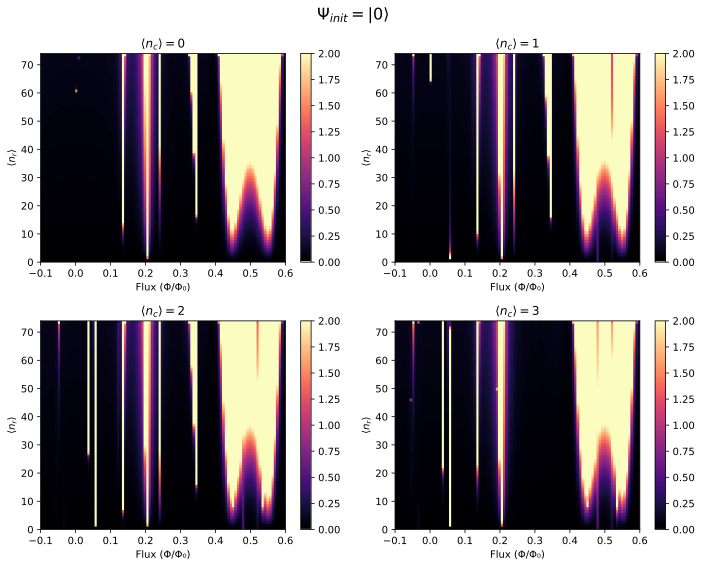

In [63]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()
n_r_list = np.arange(0, 75, 1)
extent = [flux_arr[0], flux_arr[-1], n_r_list[0], n_r_list[-1]]

for ax, key, name in zip(axes, key_list0, name_list0):
    #ax.imshow(dat0[key].T, extent=extent, cmap='magma')
    ax.set_title(name)
    ax.set_xlabel('Flux (Φ/Φ₀)')
    ax.set_ylabel(r'$⟨n_r⟩$')
    fixed = Z_fixed = np.flipud(np.fliplr(dat0[key].T))

    im = ax.imshow(fixed, extent=extent, cmap='magma', vmin=0, vmax=2)
    ax.set_aspect("auto")

    plt.colorbar(im, ax = ax)

title = r'$\Psi_{init} = |0⟩$'
fig.suptitle(title, fontsize=16)
plt.tight_layout()
plt.savefig(r'Ground State')

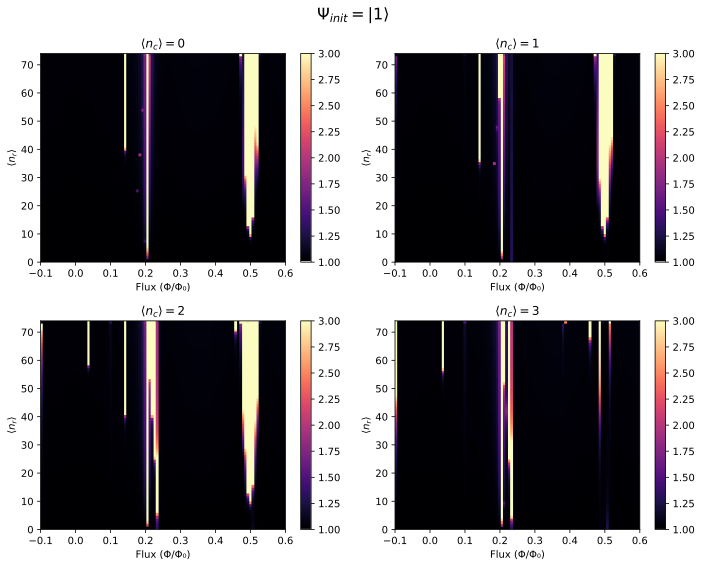

In [65]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()
n_r_list = np.arange(0, 75, 1)
extent = [flux_arr[0], flux_arr[-1], n_r_list[0], n_r_list[-1]]

for ax, key, name in zip(axes, key_list1, name_list0):
    #ax.imshow(dat0[key].T, extent=extent, cmap='magma')
    ax.set_title(name)
    ax.set_xlabel('Flux (Φ/Φ₀)')
    ax.set_ylabel(r'$⟨n_r⟩$')
    fixed = Z_fixed = np.flipud(np.fliplr(dat1[key].T))
    im = ax.imshow(fixed, extent=extent, cmap='magma', vmin=1, vmax=3)
    ax.set_aspect("auto")

    plt.colorbar(im, ax = ax)

title = r'$\Psi_{init} = |1⟩$'
fig.suptitle(title, fontsize=16)
plt.tight_layout()
plt.savefig('Excited State')

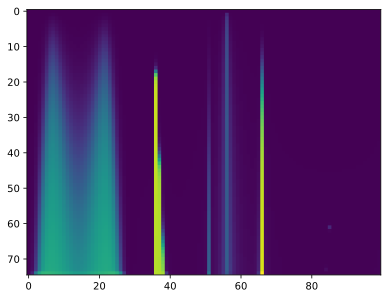

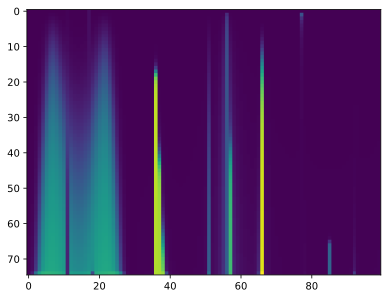

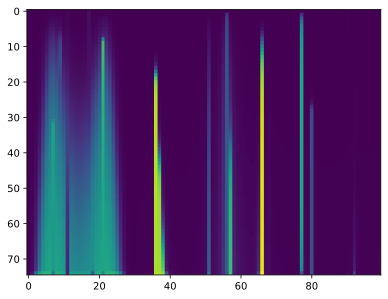

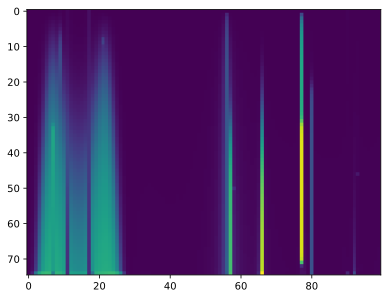

In [14]:
plt.imshow(dat0['n_q_branch=q0_c0'].T)
plt.show()
plt.imshow(dat0['n_q_branch=q0_c1'].T)
plt.show()
plt.imshow(dat0['n_q_branch=q0_c2'].T)
plt.show()
plt.imshow(dat0['n_q_branch=q0_c3'].T)
plt.show()

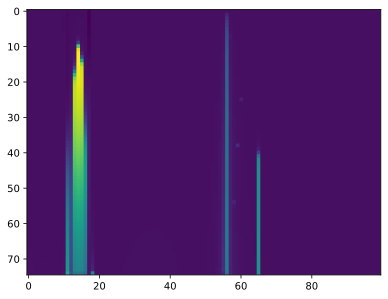

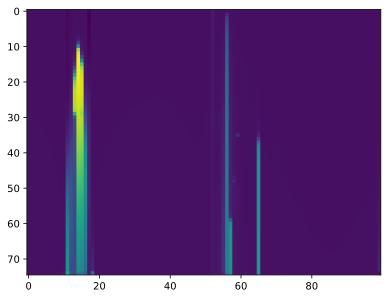

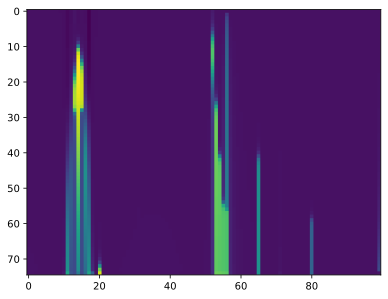

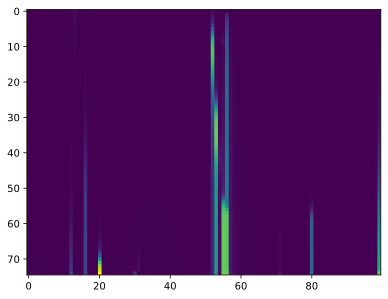

In [15]:
plt.imshow(dat1['n_q_branch=q1_c0'].T)
plt.show()
plt.imshow(dat1['n_q_branch=q1_c1'].T)
plt.show()
plt.imshow(dat1['n_q_branch=q1_c2'].T)
plt.show()
plt.imshow(dat1['n_q_branch=q1_c3'].T)
plt.show()

In [57]:
fit_params['chain_trunc'] = (None, None, None)
fit_params['cdim'] = (None, None, None)
fit_params['chain_mode'] = (None, None, None)
pkg, H_full = get_objs(fit_params, 'fluxonium')

HilbertSpace:  subsystems
-------------------------

Fluxonium-----------| [Fl]
                    | EJ: 2.04
                    | EC: 1.083
                    | EL: 0.091
                    | flux: 0.6
                    | cutoff: 15
                    | truncated_dim: 15
                    |
                    | dim: 15


Oscillator----------| [Res]
                    | E_osc: 6.627
                    | l_osc: 0.7071067811865475
                    | truncated_dim: 75
                    |
                    | dim: 75



HilbertSpace:  interaction terms
--------------------------------
InteractionTerm----------| [Interaction_1]
                         | expr: '0.062 * n * (a + adag)'
                         | operator_list: [(0, 'n', array([[ 0.+0.j        , -0.-0.22636837j ...
                         | id_wrapped_operator_list: []
                         | const: {}
                         | add_hc: False




In [58]:
flux_arr = np.linspace(-.1, .6, 80)
res_list = []
for flux in tqdm(flux_arr, ascii=True, desc="sweeping flux..."):
    
    fit_params['flux'] = (flux, r'$\Phi_0$', None)
    pkg, H_full = get_objs(fit_params, 'fluxonium', H_full,
                           update_flux=True)
    res = branch_analysis(pkg, update_flux=True)
    res_list.append(res)
    del pkg
    gc.collect()

sweeping flux...:   0%|                                                                         | 0/80 [00:03<?, ?it/s]


UnboundLocalError: cannot access local variable 'n_list3' where it is not associated with a value

In [ ]:
# Check this!!!
def embed(local_op, index, dims):
    op = None
    for i, d in enumerate(dims):
        factor = local_op if i == index else np.eye(d)
        op = factor if op is None else np.kron(op, factor)
    return op